# LinkedIn Job Postings

## ADS 508 Impacting the Business with a Distributed Data Science Pipeline

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from pyathena import connect
import awswrangler as wr
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
from io import StringIO
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

import warnings
warnings.filterwarnings('ignore')

2025-04-15 05:29:03.857828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Ingestion

### CSV to S3

In [2]:
# Setup boto3 session parameters
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Establish connection
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [3]:
# Set S3 Source Location (Public bucket)
s3_public_path = "s3://linkedin-postings"

In [4]:
%store s3_public_path

Stored 's3_public_path' (str)


In [5]:
# Set S3 Destination Location (Private bucket)
s3_private_path = "s3://{}/linkedin_data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-109784353618/linkedin_data


In [6]:
%store s3_private_path

Stored 's3_private_path' (str)


In [7]:
# Copy data from Public S3 bucket to Private S3 bucket
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "postings/postings.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "salaries/salaries.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "job_skills/job_skills.csv"

copy: s3://linkedin-postings/postings/postings.csv to s3://sagemaker-us-east-1-109784353618/linkedin_data/postings/postings.csv
copy: s3://linkedin-postings/salaries/salaries.csv to s3://sagemaker-us-east-1-109784353618/linkedin_data/salaries/salaries.csv
copy: s3://linkedin-postings/job_skills/job_skills.csv to s3://sagemaker-us-east-1-109784353618/linkedin_data/job_skills/job_skills.csv


In [8]:
# Check files are copied successfully to private bucket
!aws s3 ls $s3_private_path/

                           PRE job_skills/
                           PRE parquet/
                           PRE postings/
                           PRE preprocessing/
                           PRE salaries/


In [3]:
# Initialize boto3 client
s3 = boto3.client('s3')

# Define bucket and paths 
bucket_name = bucket
file_key = 'linkedin_data/postings/postings.csv'
cleaned_file_key = 'linkedin_data/postings/cleaned/cleaned_postings.csv'

In [9]:
# Read postings.csv directly from private bucket
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df = pd.read_csv(obj['Body'])

# Remove embedded newlines
df['description'].replace({r'[\n\r]+': ' '}, regex=True, inplace=True)
df['skills_desc'].replace({r'[\n\r]+': ' '}, regex=True, inplace=True)

# Remove embedded commas
df['company_name'].replace({r'[,]+': ' '}, regex=True, inplace=True)
df['title'].replace({r'[,]+': ' '}, regex=True, inplace=True)
df['description'].replace({r'[,]+': ' '}, regex=True, inplace=True)
df['location'].replace({r'[,]+': ' '}, regex=True, inplace=True)
df['skills_desc'].replace({r'[,]+': ' '}, regex=True, inplace=True)


# Save cleaned CSV back to S3 directly (in-memory)
csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)

s3.put_object(Bucket=bucket_name, Key=cleaned_file_key, Body=csv_buffer.getvalue())

print(f"Cleaned CSV successfully uploaded to: s3://{bucket_name}/{cleaned_file_key}")

Cleaned CSV successfully uploaded to: s3://sagemaker-us-east-1-109784353618/linkedin_data/postings/cleaned/cleaned_postings.csv


### Create Athena Database 

In [10]:
ingest_create_athena_db_passed = False

In [11]:
ingest_create_athena_table_passed = False

In [12]:
database_name = "linkedin_data"

In [13]:
# Set S3 staging directory - a temporary directory for Athena queries
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

In [14]:
# Connect to staging directory
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [15]:
# Create Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


### Verify database has been created

In [16]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,linkedin_data


In [17]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena Tables from CSV Files

In [18]:
table_name = 'postings'
postings_path = "s3://{}/linkedin_data/postings/cleaned/".format(bucket)

drop_statement = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name)

print(drop_statement)
pd.read_sql(drop_statement, conn)
print("Attempted to Drop {} table".format(table_name))

DROP TABLE IF EXISTS linkedin_data.postings;
Attempted to Drop postings table


In [19]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        company_name string,
        title string,
        description string,
        max_salary float,
        pay_period string,
        location string,
        company_id float,
        views float,
        med_salary float,
        min_salary float,
        formatted_work_type string,
        applies float,
        original_listed_time float,
        remote_allowed float,
        job_posting_url string,
        application_url string,
        application_type string,
        expiry float,
        closed_time float,
        formatted_experience_level string,
        skills_desc string,
        listed_time string,
        posting_domain string,
        sponsored int,
        work_type string,
        currency string,
        compensation_type string,
        normalized_salary float,
        zip_code int,
        fips int
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, postings_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created postings table")

Created postings table


In [20]:
table_name_2 = "salaries"
salaries_path = "s3://{}/linkedin_data/salaries/".format(bucket)

drop_statement2 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_2)

print(drop_statement2)
pd.read_sql(drop_statement2, conn)
print("Attempted to Drop {} table".format(table_name_2))

DROP TABLE IF EXISTS linkedin_data.salaries;
Attempted to Drop salaries table


In [21]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        salary_id int,
        job_id string,
        max_salary float,
        med_salary float,
        min_salary float,
        pay_period string,
        currency string,
        compensation_type string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_2, salaries_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created salaries table")

Created salaries table


In [22]:
table_name_3 = "job_skills"
job_skills_path = "s3://{}/linkedin_data/job_skills/".format(bucket)

drop_statement3 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_3)

print(drop_statement3)
pd.read_sql(drop_statement3, conn)
print("Attempted to Drop {} table".format(table_name_3))

DROP TABLE IF EXISTS linkedin_data.job_skills;
Attempted to Drop job_skills table


In [23]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        skill_abr string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_3, job_skills_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created job_skills table")

Created job_skills table


## Create Athena Parquet Tables

### Postings Parquet Table

In [24]:
table_name = "postings"
table_name_parquet = "postings_parquet"
postings_parquet_path = "s3://{}/linkedin_data/parquet/postings/".format(bucket)

# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT job_id,
        company_name,
        title,
        description,
        max_salary,
        pay_period,
        location,
        company_id,
        views,
        med_salary,
        min_salary,
        formatted_work_type,
        applies,
        original_listed_time,
        remote_allowed,
        job_posting_url,
        application_url,
        application_type,
        expiry,
        closed_time,
        formatted_experience_level,
        skills_desc,
        listed_time,
        posting_domain,
        sponsored,
        work_type,
        currency,
        compensation_type,
        normalized_salary,
        zip_code,
        fips
FROM {}.{}""".format(
    database_name, table_name_parquet, postings_parquet_path, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


### Salaries Parquet table

In [25]:
table_name = "salaries"
table_name_parquet = "salaries_parquet"
salaries_parquet_path = "s3://{}/linkedin_data/parquet/salaries/".format(bucket)

# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT salary_id,
    job_id,
    max_salary,
    med_salary,
    min_salary,
    pay_period,
    currency,
    compensation_type
FROM {}.{}""".format(
    database_name, table_name_parquet, salaries_parquet_path, database_name, table_name
)


pd.read_sql(statement, conn)

,rows


### Job Skills Parquet table

In [26]:
table_name = "job_skills"
table_name_parquet = "job_skills_parquet"
job_skills_parquet_path = "s3://{}/linkedin_data/parquet/job_skills/".format(bucket)

# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT job_id,
        skill_abr
FROM {}.{}""".format(
    database_name, table_name_parquet, job_skills_parquet_path, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


### Verify tables have been created successfully

In [27]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(10)

,tab_name
0,job_skills
1,job_skills_parquet
2,postings
3,postings_parquet
4,salaries
5,salaries_parquet
6,temp_table_74d7206da0ef456588805954f5bcaaaa


In [28]:
if table_name in df_show.values:
    ingest_create_athena_table_passed = True

In [29]:
# View postings table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, 'postings_parquet')

pd.read_sql(statement, conn)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,3787839455,Cold Storage Recruiting,Building Maintenance Manager,Job Summary:Responsible for coordinating and o...,125000.0,YEARLY,Elizabeth NJ,100542464.0,14.0,None,...,,1713400172000.0,,0,FULL_TIME,USD,BASE_SALARY,117500.0,7201,34039
1,3788295344,,Veterinarian,***FARMINGTON VETERINARY CLINIC*** Farmington ...,NaN,,Farmington MN,NaN,15.0,None,...,,1713388355000.0,,0,PART_TIME,,,NaN,55024,27037
2,3788738919,,Armed Security Guard,We are looking for an armed security officer i...,NaN,,Bel Air MD,NaN,2.0,None,...,,1713277040000.0,,0,FULL_TIME,,,NaN,21014,24025
3,3788980998,Marsh McLennan Agency,Senior Account Executive,ESSENTIAL DUTIES & RESPONSIBILITIES: Documenta...,NaN,,Dallas TX,33247784.0,25.0,None,...,,1713459221000.0,,0,FULL_TIME,,,NaN,75201,48113
4,3789379757,DICK'S Sporting Goods,Bench Store Manager,At DICK’S Sporting Goods we believe in how po...,NaN,,Portland OR,7789.0,31.0,None,...,,1713455296000.0,,0,FULL_TIME,,,NaN,97201,41051


In [30]:
# View salaries table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, 'salaries_parquet')

pd.read_sql(statement, conn)

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


In [31]:
# View job_skills table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, 'job_skills_parquet')

pd.read_sql(statement, conn)

,job_id,skill_abr
0,3888930939,ENG
1,3888937329,RSCH
2,3888937329,ANLS
3,3888937329,IT
4,3887577129,MGMT


## Data Exploration

In [32]:
postings_df = wr.athena.read_sql_query("""SELECT * FROM postings_parquet""", database=database_name)

2025-04-15 03:59:38,418	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1910452224 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.41gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-04-15 03:59:39,770	INFO worker.py:1786 -- Started a local Ray instance.


In [33]:
salaries_df = wr.athena.read_sql_query("""SELECT * FROM salaries_parquet""", database=database_name)

In [34]:
job_skills_df = wr.athena.read_sql_query("""SELECT * FROM job_skills_parquet""", database=database_name)

### postings EDA

In [35]:
# Basic info
postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  string 
 1   company_name                123849 non-null  string 
 2   title                       123849 non-null  string 
 3   description                 123849 non-null  string 
 4   max_salary                  29793 non-null   float32
 5   pay_period                  123849 non-null  string 
 6   location                    123849 non-null  string 
 7   company_id                  122132 non-null  float32
 8   views                       122160 non-null  float32
 9   med_salary                  6280 non-null    float32
 10  min_salary                  29793 non-null   float32
 11  formatted_work_type         123849 non-null  string 
 12  applies                     23320 non-null   float32
 13  original_liste

In [36]:
# Missing values
postings_df.isnull().sum()

job_id                             0
company_name                       0
title                              0
description                        0
max_salary                     94056
pay_period                         0
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                    0
application_type                   0
expiry                            59
closed_time                   122732
formatted_experience_level         0
skills_desc                        0
listed_time                        0
posting_domain                     0
sponsored                         59
work_type                          0
currency                           0
c

In [37]:
# Duplicates
duplicates = postings_df.duplicated().sum()
print(duplicates)

0


In [38]:
# Summary statistics for numerical columns
print(postings_df.describe())

         max_salary   company_id          views     med_salary    min_salary  \
count  2.979300e+04     122132.0  122160.000000    6280.000000  2.979300e+04   
mean   9.193942e+04   12204012.0      14.618247   22015.617188  6.491085e+04   
std    7.011102e+05   25541432.0      85.903595   52255.871094  4.959738e+05   
min    1.000000e+00       1009.0       1.000000       0.000000  1.000000e+00   
25%    4.828000e+01      14352.0       3.000000      18.940001  3.700000e+01   
50%    8.000000e+04     226965.0       4.000000      25.500000  6.000000e+04   
75%    1.400000e+05    8047188.0       8.000000    2510.500000  1.000000e+05   
max    1.200000e+08  103472976.0    9975.000000  750000.000000  8.500000e+07   

            applies  original_listed_time  remote_allowed        expiry  \
count  23320.000000          1.238490e+05         15246.0  1.237900e+05   
mean      10.591981          1.713152e+12             1.0  1.716213e+12   
std       29.047396          4.848199e+08             

In [39]:
# Top 10 unique values in categorical columns
categorical = ["title", "zip_code", "formatted_work_type", "remote_allowed"]
for col in categorical:
    print(postings_df[col].value_counts().head(10))

title
Sales Manager                      673
Customer Service Representative    373
Project Manager                    354
Administrative Assistant           254
Senior Accountant                  238
Executive Assistant                228
Salesperson                        211
Registered Nurse                   210
Receptionist                       204
Staff Accountant                   200
Name: count, dtype: Int64
zip_code
10001    2761
60601    1837
77002    1762
75201    1398
30303    1366
2108     1176
78701    1083
28202    1075
85003    1062
90001    1058
Name: count, dtype: Int64
formatted_work_type
Full-time     98814
Contract      12117
Part-time      9696
Temporary      1190
Internship      983
Volunteer       562
Other           487
Name: count, dtype: Int64
remote_allowed
1.0    15246
Name: count, dtype: int64


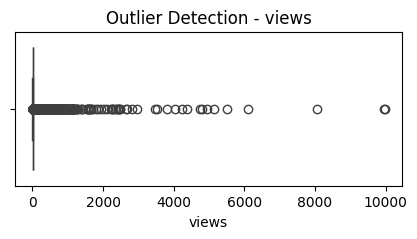

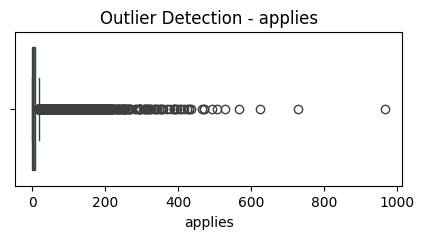

In [40]:
# Detect Outliers using box plots
numerical = ["views", "applies"]
for col in numerical:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=postings_df[col])
    plt.title(f"Outlier Detection - {col}")
    plt.show()

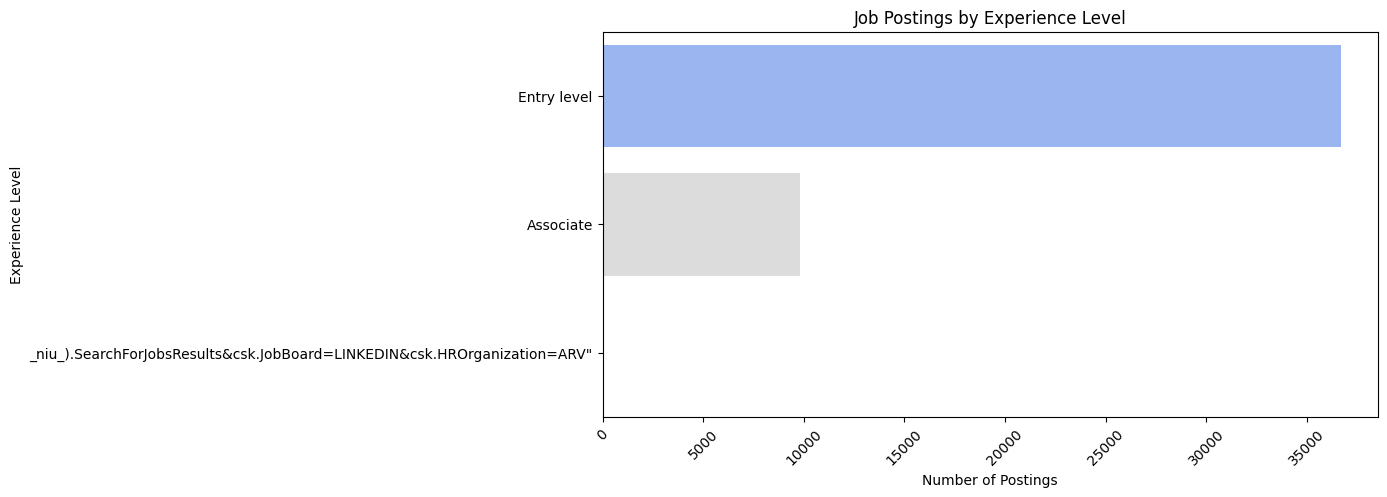

In [41]:
# Visualize experience level distribution
top_titles = postings_df["formatted_experience_level"].value_counts().iloc[[1,3,7]]

plt.figure(figsize=(10,5))
sns.barplot(y=top_titles.index, x=top_titles.values, palette="coolwarm")
plt.xlabel("Number of Postings")
plt.ylabel("Experience Level")
plt.title("Job Postings by Experience Level")
plt.xticks(rotation=45)
plt.show()

### salaries EDA

In [42]:
# Basic stats
print(salaries_df.describe())
print(salaries_df.info())

          salary_id    max_salary     med_salary    min_salary
count       40785.0  3.394700e+04    6838.000000  3.394700e+04
mean        20393.0  9.620987e+04   21370.296875  6.508541e+04
std    11773.759701  6.587374e+05   51338.566406  4.650612e+05
min             1.0  1.000000e+00       0.000000  1.000000e+00
25%         10197.0  5.000000e+01      18.500000  3.900000e+01
50%         20393.0  8.500000e+04      25.000000  6.230000e+04
75%         30589.0  1.425000e+05    2207.000000  1.000000e+05
max         40785.0  1.200000e+08  750000.000000  8.500000e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40785 entries, 0 to 40784
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary_id          40785 non-null  Int32  
 1   job_id             40785 non-null  string 
 2   max_salary         33947 non-null  float32
 3   med_salary         6838 non-null   float32
 4   min_salary         33947 non-nul

In [43]:
# Missing values
salaries_df.isnull().sum()

salary_id                0
job_id                   0
max_salary            6838
med_salary           33947
min_salary            6838
pay_period               0
currency                 0
compensation_type        0
dtype: int64

In [44]:
# Duplicates
salaries_df.duplicated().sum()

0

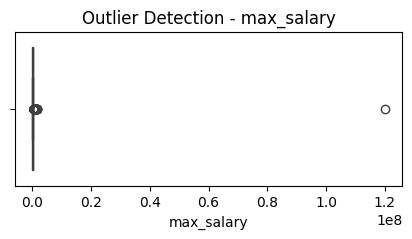

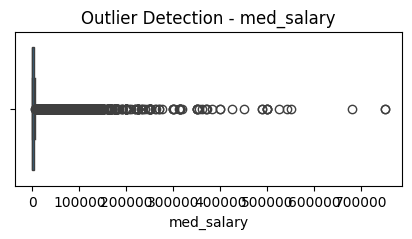

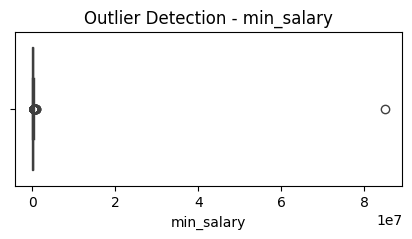

In [45]:
# Detect Outliers using box plots
numerical = ["max_salary", "med_salary", "min_salary"]
for col in numerical:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=postings_df[col])
    plt.title(f"Outlier Detection - {col}")
    plt.show()

In [46]:
# Salary distributions
salary_columns = ["min_salary", "med_salary", "max_salary"]
print(salaries_df[salary_columns].describe())

         min_salary     med_salary    max_salary
count  3.394700e+04    6838.000000  3.394700e+04
mean   6.508541e+04   21370.296875  9.620987e+04
std    4.650612e+05   51338.566406  6.587374e+05
min    1.000000e+00       0.000000  1.000000e+00
25%    3.900000e+01      18.500000  5.000000e+01
50%    6.230000e+04      25.000000  8.500000e+04
75%    1.000000e+05    2207.000000  1.425000e+05
max    8.500000e+07  750000.000000  1.200000e+08


array([[<Axes: title={'center': 'salary_id'}>,
        <Axes: title={'center': 'max_salary'}>],
       [<Axes: title={'center': 'med_salary'}>,
        <Axes: title={'center': 'min_salary'}>]], dtype=object)

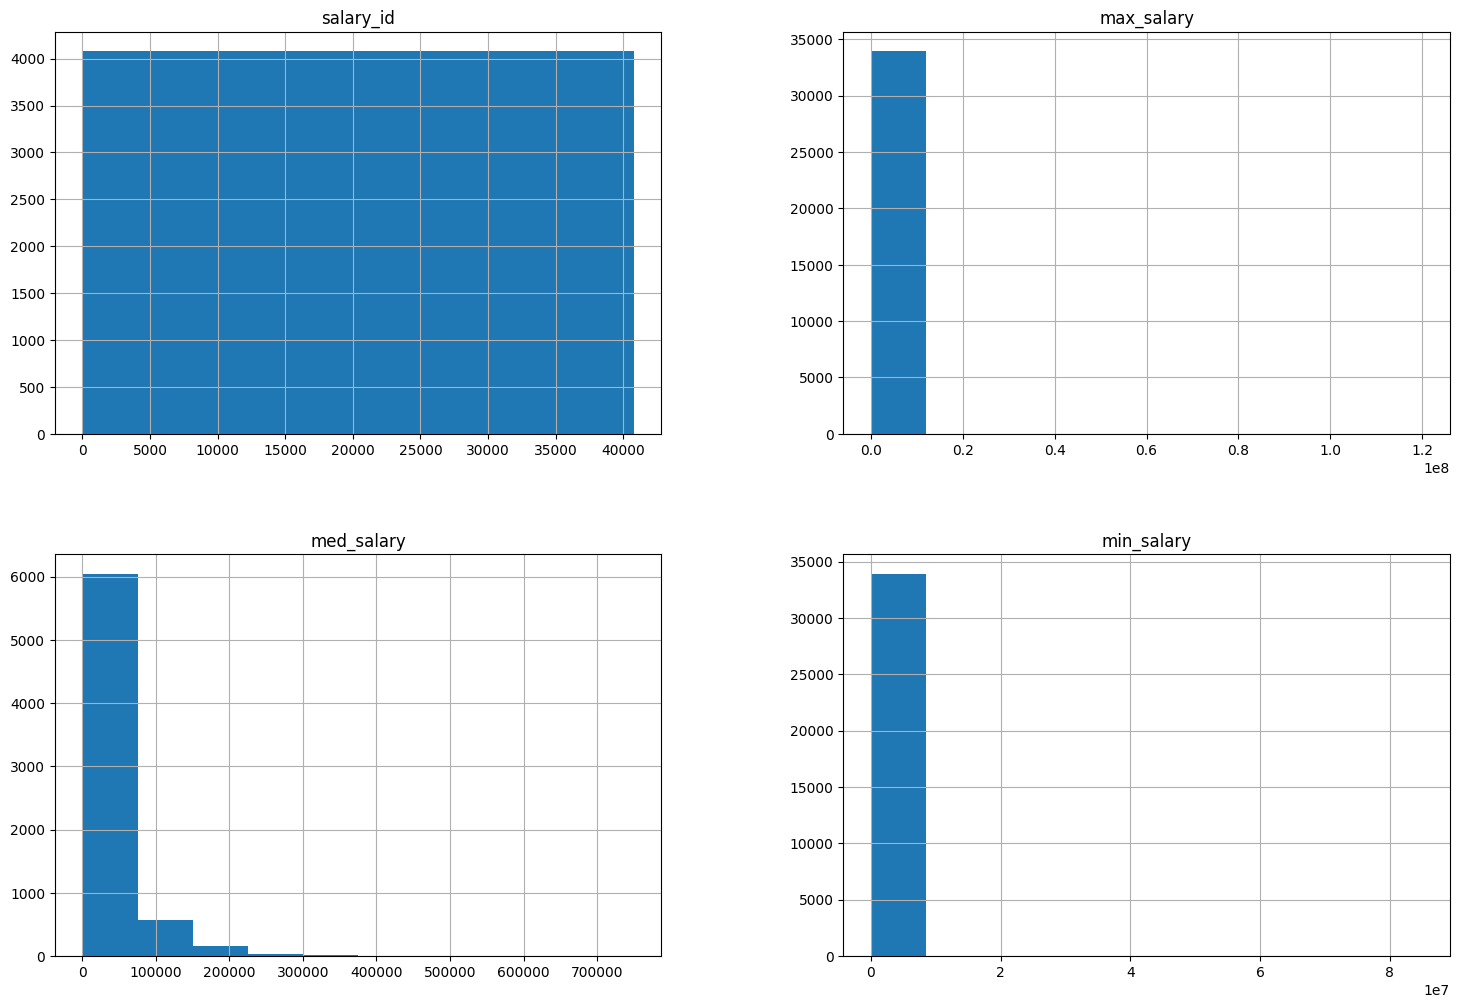

In [47]:
salaries_df.hist(figsize=(18,12))

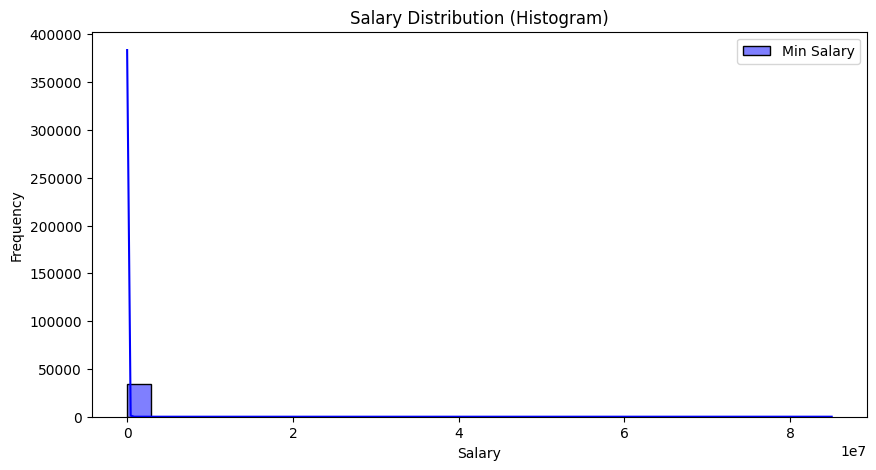

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["min_salary"], color="blue", kde=True, label="Min Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

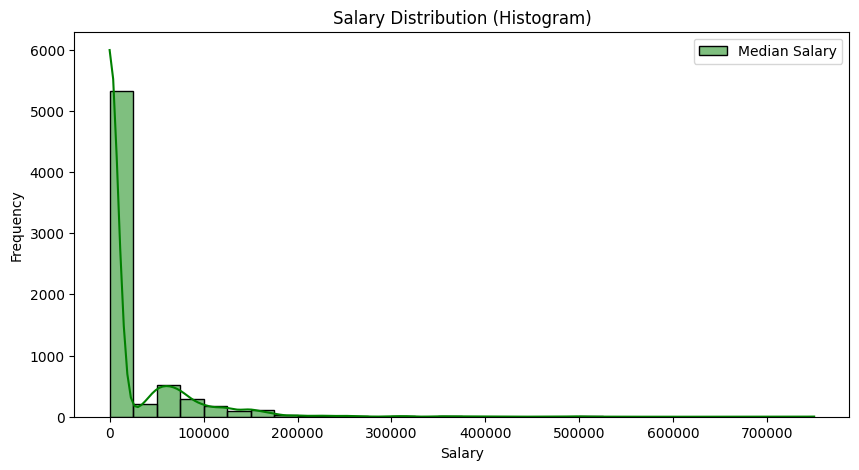

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["med_salary"], color="green", kde=True, label="Median Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

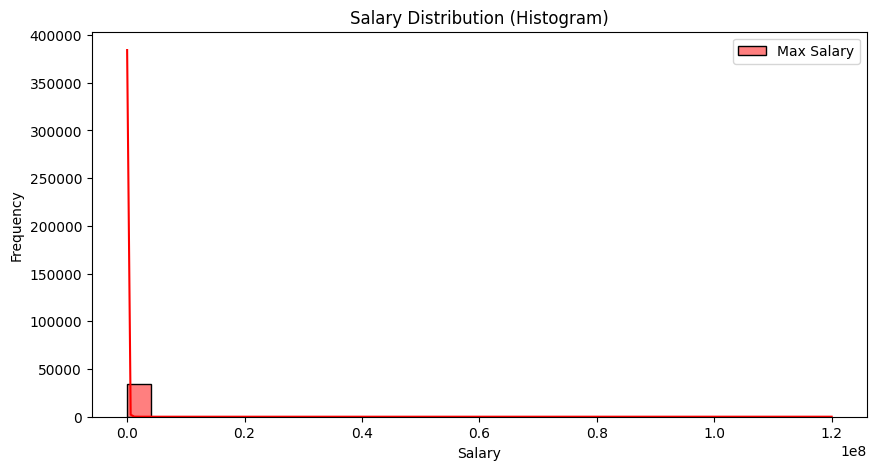

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["max_salary"], color="red", kde=True, label="Max Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### job_skills EDA

In [51]:
# Basic info
print(job_skills_df.describe())
print(job_skills_df.info())

            job_id skill_abr
count       213768    213768
unique      126807        35
top     3902322743        IT
freq             3     26137
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213768 entries, 0 to 213767
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   job_id     213768 non-null  string
 1   skill_abr  213768 non-null  string
dtypes: string(2)
memory usage: 3.3 MB
None


In [52]:
# Missing values
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [53]:
# Duplicates
job_skills_df.duplicated().sum()

0

In [54]:
# Unique skills
print(f"Unique Job Skills: {job_skills_df['skill_abr'].nunique()}")

Unique Job Skills: 35


In [55]:
# Skill frequencies
job_skills_df["skill_abr"] = job_skills_df["skill_abr"].astype(str)  # Ensure it's a string
skills = job_skills_df["skill_abr"].str.split(",").explode().str.strip().value_counts()
print(skills.head(20))

skill_abr
IT      26137
SALE    22475
MGMT    20861
MNFC    18185
HCPR    17369
BD      14290
ENG     13009
OTHR    12608
FIN      8540
MRKT     5525
ACCT     5461
ADM      4860
CUST     4292
PRJM     3997
ANLS     3858
RSCH     2986
HR       2647
LGL      2371
CNSL     2338
EDU      2290
Name: count, dtype: int64


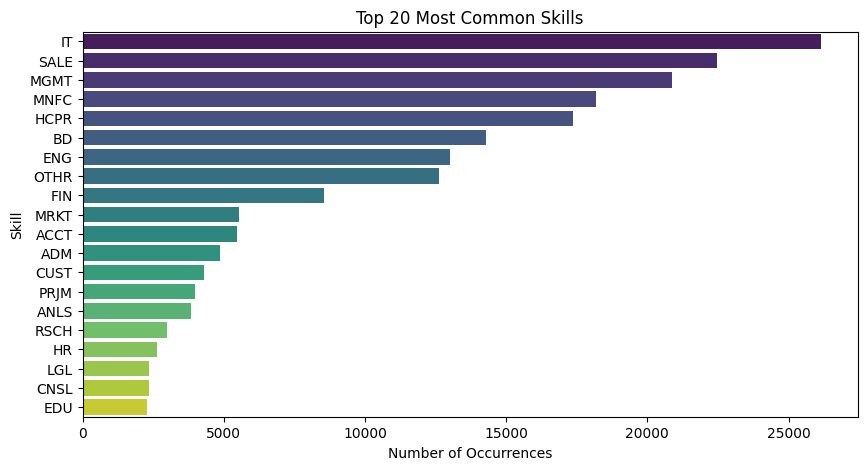

In [56]:
# Concatenate all skills descriptions
all_skills = " ".join(job_skills_df["skill_abr"].dropna())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_skills)

# Bar Chart of Top 20 Most Common Skills
top_skills = skills.head(20)

plt.figure(figsize=(10, 5))
sns.barplot(y=top_skills.index, x=top_skills.values, palette="viridis")
plt.title("Top 20 Most Common Skills")
plt.xlabel("Number of Occurrences")
plt.ylabel("Skill")
plt.show()

### Pre-Processing

In [57]:
# Missing values - postings_df
postings_df.isnull().sum()

job_id                             0
company_name                       0
title                              0
description                        0
max_salary                     94056
pay_period                         0
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                    0
application_type                   0
expiry                            59
closed_time                   122732
formatted_experience_level         0
skills_desc                        0
listed_time                        0
posting_domain                     0
sponsored                         59
work_type                          0
currency                           0
c

In [58]:
# Missing values - salaries_df
salaries_df.isnull().sum()

salary_id                0
job_id                   0
max_salary            6838
med_salary           33947
min_salary            6838
pay_period               0
currency                 0
compensation_type        0
dtype: int64

In [59]:
# Missing values - job_skills_df
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [60]:
# Remove unnecessary columns
columns_to_keep = ['job_id', 'title', 'pay_period', 'remote_allowed', 'formatted_work_type', 'zip_code']
postings_df = postings_df[columns_to_keep]

In [61]:
postings_df.head()

,job_id,title,pay_period,remote_allowed,formatted_work_type,zip_code
0,921716,Marketing Coordinator,HOURLY,NaN,Full-time,8540
1,1829192,Mental Health Therapist/Counselor,HOURLY,NaN,Full-time,80521
2,10998357,Assitant Restaurant Manager,YEARLY,NaN,Full-time,45202
3,23221523,Senior Elder Law / Trusts and Estates Associat...,YEARLY,NaN,Full-time,11040
4,35982263,Service Technician,YEARLY,NaN,Full-time,52601


In [62]:
# Remove missing values in pay_period column
postings_df = postings_df.dropna(subset=['pay_period'])

In [63]:
# Fill in empty cells with 0 for remote NOT allowed
postings_df['remote_allowed'].fillna(0, inplace=True)

In [64]:
# Removed .0 at the end of all zipcodes and filled NaN with 0
postings_df['zip_code'] = postings_df['zip_code'].fillna(0).astype(int).astype(str)

In [65]:
# Double check df looks right
postings_df.info()
postings_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   job_id               123849 non-null  string 
 1   title                123849 non-null  string 
 2   pay_period           123849 non-null  string 
 3   remote_allowed       123849 non-null  float32
 4   formatted_work_type  123849 non-null  string 
 5   zip_code             123849 non-null  object 
dtypes: float32(1), object(1), string(4)
memory usage: 5.2+ MB


job_id                 0
title                  0
pay_period             0
remote_allowed         0
formatted_work_type    0
zip_code               0
dtype: int64

In [66]:
# Fill NaN with median of respective column
salaries_df['max_salary'].fillna(salaries_df['max_salary'].median(), inplace=True)
salaries_df['min_salary'].fillna(salaries_df['min_salary'].median(), inplace=True)
salaries_df['med_salary'].fillna(salaries_df['med_salary'].median(), inplace=True)

In [67]:
# Ensure there are no incorrect data types for salaries
salaries_df['max_salary'] = pd.to_numeric(salaries_df['max_salary'], errors='coerce')
salaries_df['min_salary'] = pd.to_numeric(salaries_df['min_salary'], errors='coerce')
salaries_df['med_salary'] = pd.to_numeric(salaries_df['med_salary'], errors='coerce')

In [68]:
# write pre-processed df to S3
csv_buffer = StringIO()
postings_df.to_csv(csv_buffer, index=False)
file_key = 'linkedin_data/postings/preprocessing/postings.csv'

s3.put_object(Bucket=bucket, Key=file_key, Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'V73F4Z995SMFHDCZ',
  'HostId': '3XGKYq7iToNfF+wP5LXk1wFw7QNRfDulLV5jarJ0gfwRP7wAuxnRJBiNsNUbL7lctK8g5sDGGrs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '3XGKYq7iToNfF+wP5LXk1wFw7QNRfDulLV5jarJ0gfwRP7wAuxnRJBiNsNUbL7lctK8g5sDGGrs=',
   'x-amz-request-id': 'V73F4Z995SMFHDCZ',
   'date': 'Tue, 15 Apr 2025 04:00:03 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"ec00c79b1efe9ceaa86fc8d433a95e74"',
   'x-amz-checksum-crc32': 'KVpW9w==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"ec00c79b1efe9ceaa86fc8d433a95e74"',
 'ChecksumCRC32': 'KVpW9w==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}

## Data Transformations

### Create embeddings for title

In [69]:
# create the processor instance
sklearn_processor = SKLearnProcessor(
    framework_version="0.20.0",
    role=role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
)

In [70]:
# check the input data
key_file = 'linkedin_data/postings/preprocessing/postings.csv'
input_data = 's3://{}/{}'.format(bucket, key_file)
obj = s3.get_object(Bucket=bucket, Key=key_file)
df = pd.read_csv(obj['Body'], nrows=10)
df.head(n=10)

,job_id,title,pay_period,remote_allowed,formatted_work_type,zip_code
0,921716,Marketing Coordinator,HOURLY,0.0,Full-time,8540
1,1829192,Mental Health Therapist/Counselor,HOURLY,0.0,Full-time,80521
2,10998357,Assitant Restaurant Manager,YEARLY,0.0,Full-time,45202
3,23221523,Senior Elder Law / Trusts and Estates Associat...,YEARLY,0.0,Full-time,11040
4,35982263,Service Technician,YEARLY,0.0,Full-time,52601
5,91700727,Economic Development and Planning Intern,HOURLY,0.0,Internship,27601
6,103254301,Producer,YEARLY,1.0,Contract,0
7,112576855,Building Engineer,YEARLY,0.0,Full-time,94101
8,1218575,Respiratory Therapist,NaN,0.0,Full-time,68102
9,2264355,Worship Leader,MONTHLY,0.0,Part-time,32905


### Define the processing job

In [71]:
%%writefile preprocessing.py 
import os

os.system('pip install sentence-transformers')

if __name__ == '__main__':
    from sentence_transformers import SentenceTransformer
    from sklearn.decomposition import PCA
    
    categorical_columns = ['zip_code', 'formatted_work_type', 'remote_allowed', 'pay_period']
    
    model = SentenceTransformer("all-MiniLM-L6-v2") # SBERT, not case-sensitive

    input_data_path = os.path.join('/opt/ml/processing/input', 'postings.csv')

    print("Reading input data from {}".format(input_data_path))
    df = pd.read_csv(input_data_path)
    
    # create embeddings for 'title'
    print('Creating embeddings for job title')
    df["title_embeddings"] = df["title"].apply(lambda x: model.encode(x))

    # Use PCA to reduce the embeddings vector down to 2 dimensions 
    print('Reducing embeddings to 2 dimensions')
    pca = PCA(n_components=2, svd_solver='full')
    embeddings_matrix = np.vstack(df['title_embeddings'].values)
    reduced_embeddings = pca.fit_transform(embeddings_matrix)
    
    df['pca_1'] = reduced_embeddings[:, 0]
    df['pca_2'] = reduced_embeddings[:, 1]

    # One hot encode categorical fields
    df = pd.get_dummies(df, columns=categorical_columns)
    
    # save csv to output_path
    output_path = os.path.join('/opt/ml/processing/output', 'postings.csv')
    df.to_csv(output_path, index=False)

Overwriting preprocessing.py


### Execute the processing job

In [72]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "preprocessing/postings.csv"

copy: s3://linkedin-postings/preprocessing/postings.csv to s3://sagemaker-us-east-1-109784353618/linkedin_data/preprocessing/postings.csv


In [4]:
# check if processing has been performed before
obj = s3.get_object(
    Bucket= session.default_bucket(),
    Key='linkedin_data/preprocessing/postings.csv'
)

if not obj:
    # run the processing job
    sklearn_processor.run(
        code="preprocessing.py",
        inputs=[ProcessingInput(source=input_data, destination="/opt/ml/processing/input")],
        outputs=[
            ProcessingOutput(output_name="processed_postings", source="/opt/ml/processing/output")
        ]
    )
    
    preprocessing_job_description = sklearn_processor.jobs[-1].describe()
    
    output_config = preprocessing_job_description["ProcessingOutputConfig"]
    for output in output_config["Outputs"]:
        if output["OutputName"] == "processed_postings":
            preprocessed_data = output["S3Output"]["S3Uri"]
            
            # check output of processing job
            df = pd.read_csv(preprocessed_data + "/postings.csv", nrows=10)
            df.head(n=10)

In [5]:
print(obj)

{'ResponseMetadata': {'RequestId': 'N27MTZM9TBB4XYT6', 'HostId': 'EpN+DX34iPjCTmisX1uefTkEJjoG3UUZG/qOkfu/XpteHLolxdwbSQwtj9PAKxc+BA7wfgX62XU=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'EpN+DX34iPjCTmisX1uefTkEJjoG3UUZG/qOkfu/XpteHLolxdwbSQwtj9PAKxc+BA7wfgX62XU=', 'x-amz-request-id': 'N27MTZM9TBB4XYT6', 'date': 'Tue, 15 Apr 2025 05:29:28 GMT', 'last-modified': 'Tue, 15 Apr 2025 04:00:05 GMT', 'etag': '"909d9b6257a24156b7e01f6e0af7e289-621"', 'x-amz-checksum-crc64nvme': 'klJVYbmIDjM=', 'x-amz-checksum-type': 'FULL_OBJECT', 'x-amz-server-side-encryption': 'AES256', 'accept-ranges': 'bytes', 'content-type': 'text/csv', 'content-length': '5208905474', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'AcceptRanges': 'bytes', 'LastModified': datetime.datetime(2025, 4, 15, 4, 0, 5, tzinfo=tzutc()), 'ContentLength': 5208905474, 'ETag': '"909d9b6257a24156b7e01f6e0af7e289-621"', 'ChecksumCRC64NVME': 'klJVYbmIDjM=', 'ChecksumType': 'FULL_OBJECT', 'ContentType': 'text/csv', 'ServerSideEncr

In [6]:
from sklearn.model_selection import train_test_split

base_path = 'linkedin_data/partition'

# Upload helper function
def upload_df_to_s3(df, key):
    buffer = StringIO()
    df.to_csv(buffer, index=False)
    s3.put_object(Bucket=bucket_name, Key=key, Body=buffer.getvalue())
    print(f"Uploaded to s3://{bucket_name}/{key}")

df = pd.read_csv(obj['Body'])

# Step 1: 80% train, 20% temp
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)

# Step 2: Split the remaining 20% evenly
df_validate, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Confirm the splits
print("Train shape:", df_train.shape)
print("Validate shape:", df_validate.shape)
print("Test shape:", df_test.shape)

Train shape: (99079, 7003)
Validate shape: (12385, 7003)
Test shape: (12385, 7003)


In [7]:
df_train.to_csv('train.csv')
df_validate.to_csv('validate.csv')
df_test.to_csv('test.csv')

In [8]:
# Upload partitions to S3
s3.upload_file('train.csv', bucket_name, f'{base_path}/train/train.csv')
s3.upload_file('validate.csv', bucket_name, f'{base_path}/validate/validate.csv')
s3.upload_file('test.csv', bucket_name, f'{base_path}/test/test.csv')

### Model Training

In [6]:
df = pd.read_csv('train.csv', nrows=10000) # needed to reduce training sample to 10,000 due to S3 resource limitations

# Convert to NumPy
train_np = df.to_numpy()

# Record shape
num_records = train_np.shape[0]
feature_dim = train_np.shape[1]

print("Training shape:", train_np.shape)


Training shape: (10000, 7004)


In [7]:
# Your preprocessing
df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool'])
train_np = df_numeric.astype('float32').to_numpy()

# Insert this
from sagemaker.image_uris import retrieve
from sagemaker import KMeans

container = retrieve('kmeans', region=region)

kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    k=5,
    output_path=f's3://{bucket}/output/kmeans/',
    sagemaker_session=session,
    image_uri=container,
    mini_batch_size=max(500, int(num_records * 0.05))
)

# Now this will work
train_data = kmeans.record_set(train_np)
kmeans.fit(train_data)


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2025-04-15 05:30:42 Starting - Starting the training job...
2025-04-15 05:31:08 Starting - Preparing the instances for trainingProfilerReport-1744695041: InProgress
...
2025-04-15 05:31:28 Downloading - Downloading input data......
2025-04-15 05:32:28 Downloading - Downloading the training image......
2025-04-15 05:33:42 Training - Training image download completed. Training in progress.
2025-04-15 05:33:42 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[04/15/2025 05:33:30 INFO 140300556273472] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 

In [116]:
# Deploy the trained KMeans model
kmeans_predictor = kmeans.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--------!

In [124]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set serialization for inference
kmeans_predictor.serializer = CSVSerializer()
kmeans_predictor.deserializer = JSONDeserializer()

def predict_in_batches(predictor, data, batch_size=1000):
    predictions = []

    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        result = predictor.predict(batch)
        batch_preds = [int(pred['closest_cluster']) for pred in result['predictions']]
        predictions.extend(batch_preds)

    return predictions



In [129]:
# Convert the first row into CSV string format
single_row = ",".join(map(str, input_data[0]))

# Run a single prediction to test endpoint compatibility
response = kmeans_predictor.predict(single_row)
print(response)


{'predictions': [{'closest_cluster': 0.0, 'distance_to_cluster': 581737.4375}]}


In [ ]:
# Predict cluster assignments in batches
#assignments = predict_in_batches(kmeans_predictor, input_data)

# Add predictions to DataFrame
#df_with_clusters = df.copy()
#df_with_clusters['cluster'] = assignments

#df_with_clusters.head()


In [130]:
# Keep only numeric features
df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool'])

# Convert to float32
input_data = df_numeric.astype('float32').to_numpy()

# Fit local KMeans model
from sklearn.cluster import KMeans
kmeans_local = KMeans(n_clusters=5, random_state=42)
kmeans_local.fit(input_data)

# Add predictions
assignments = kmeans_local.labels_
df_with_clusters = df.copy()
df_with_clusters['cluster'] = assignments

# PCA for plotting
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(input_data)

df_with_clusters['pca_1'] = pca_result[:, 0]
df_with_clusters['pca_2'] = pca_result[:, 1]

df_with_clusters.head()


,job_id,title,pay_period,remote_allowed,formatted_work_type,zip_code,cluster,pca_1,pca_2
0,921716,Marketing Coordinator,HOURLY,0.0,Full-time,8540,2,-3.560742e+09,-36983.320312
1,23221523,Senior Elder Law / Trusts and Estates Associat...,YEARLY,0.0,Full-time,11040,2,-3.538442e+09,-34437.429688
2,35982263,Service Technician,YEARLY,0.0,Full-time,52601,2,-3.525681e+09,7149.828125
3,91700727,Economic Development and Planning Intern,HOURLY,0.0,Internship,27601,2,-3.469962e+09,-17735.515625
4,103254301,Producer,YEARLY,1.0,Contract,0,2,-3.458409e+09,-45312.742188


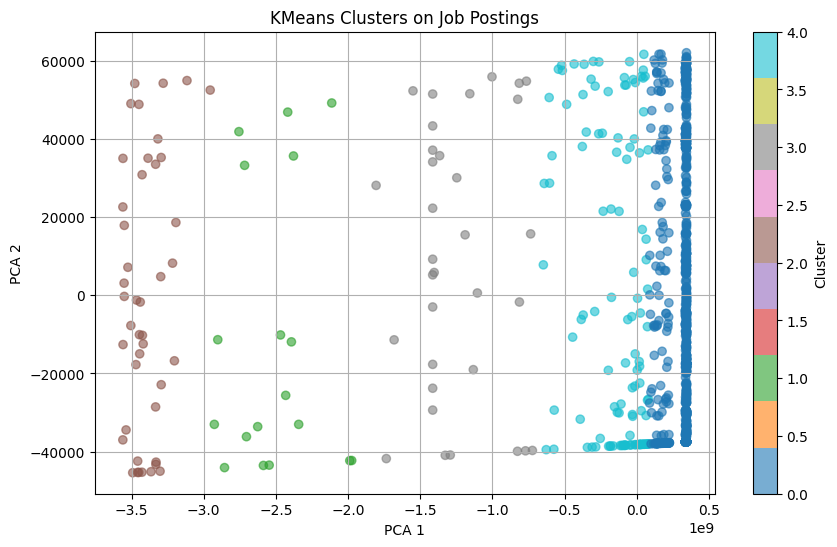

In [131]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_with_clusters['pca_1'], 
    df_with_clusters['pca_2'], 
    c=df_with_clusters['cluster'], 
    cmap='tab10', 
    alpha=0.6
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters on Job Postings')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [132]:
# Load test set
obj_test = s3.get_object(
    Bucket= session.default_bucket(),
    Key='linkedin_data/partition/test/test.csv'
)
df_test = pd.read_csv(obj_test['Body'])

# Load validation set
obj_val = s3.get_object(
    Bucket= session.default_bucket(),
    Key='linkedin_data/partition/validate/validate.csv'
)
df_val = pd.read_csv(obj_val['Body'])


In [133]:
# df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool'])

# Keep only numeric features and convert to float32
df_test_numeric = df_test[df_numeric.columns].astype('float32')
df_val_numeric = df_val[df_numeric.columns].astype('float32')

# Convert to NumPy arrays
test_input = df_test_numeric.to_numpy()
val_input = df_val_numeric.to_numpy()

# Sanity check
print("Test shape:", test_input.shape, "| dtype:", test_input.dtype)
print("Val shape:", val_input.shape, "| dtype:", val_input.dtype)


Test shape: (1, 3) | dtype: float32
Val shape: (1, 3) | dtype: float32


In [134]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

kmeans_predictor.serializer = CSVSerializer()
kmeans_predictor.deserializer = JSONDeserializer()


In [135]:
def predict_in_batches(predictor, data, batch_size=1000):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        result = predictor.predict(batch)
        batch_preds = [int(pred['closest_cluster']) for pred in result['predictions']]
        predictions.extend(batch_preds)
    return predictions


In [136]:
test_assignments = predict_in_batches(kmeans_predictor, test_input, batch_size=250)
val_assignments = predict_in_batches(kmeans_predictor, val_input, batch_size=250)


In [137]:
df_test['cluster'] = test_assignments

df_test.head()

,job_id,title,pay_period,remote_allowed,formatted_work_type,zip_code,cluster
0,23221523,Senior Elder Law / Trusts and Estates Associat...,YEARLY,0.0,Full-time,11040,2


In [138]:
df_val['cluster'] = val_assignments
df_val.head()

,job_id,title,pay_period,remote_allowed,formatted_work_type,zip_code,cluster
0,1218575,Respiratory Therapist,NaN,0.0,Full-time,68102,0


In [149]:
def upload_to_s3(df, key):
    buffer = StringIO()
    df.to_csv(buffer, index=False)
    s3.put_object(
        Bucket= session.default_bucket(),
        Key=key,
        Body=buffer.getvalue()
    )
    print(f"Uploaded to s3://private-bucket/{key}")

upload_to_s3(df_test, 'linkedin_data/partitions/predictions/test_with_clusters.csv')
upload_to_s3(df_val, 'linkedin_data/partitions/predictions/val_with_clusters.csv')


Uploaded to s3://private-bucket/linkedin_data/partitions/predictions/test_with_clusters.csv
Uploaded to s3://private-bucket/linkedin_data/partitions/predictions/val_with_clusters.csv


In [151]:
print("Shape:", df_test_numeric.shape)
print("Columns:", df_test_numeric.columns.tolist())


Shape: (1, 4)
Columns: ['job_id', 'remote_allowed', 'zip_code', 'cluster']


In [150]:
from io import StringIO
from sklearn.decomposition import PCA

# Load test set with cluster assignments from correct S3 path
bucket = session.default_bucket()
key = 'linkedin_data/partitions/predictions/test_with_clusters.csv'

obj = s3.get_object(Bucket=bucket, Key=key)
df_test = pd.read_csv(obj['Body'])

# Re-apply PCA to test set numeric features
df_test_numeric = df_test.select_dtypes(include=['int64', 'float64', 'bool']).astype('float32')
pca_test = PCA(n_components=2)
pca_result = pca_test.fit_transform(df_test_numeric)

df_test['pca_1'] = pca_result[:, 0]
df_test['pca_2'] = pca_result[:, 1]

df_test.head()


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [140]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_test['pca_1'],
    df_test['pca_2'],
    c=df_test['cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters - Test Set')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


KeyError: 'pca_1'

<Figure size 1000x600 with 0 Axes>

In [141]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_val['pca_1'],
    df_val['pca_2'],
    c=df_val['cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters - Validation Set')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


KeyError: 'pca_1'

<Figure size 1000x600 with 0 Axes>

In [142]:
### Evaluating With Silhouette 

In [143]:
from sklearn.metrics import silhouette_score

# Make sure only using numeric columns used in clustering
X_train = df_with_clusters[df_numeric.columns]
X_test = df_test[df_numeric.columns]
X_val = df_val[df_numeric.columns]

# Get the cluster assignments
labels_train = df_with_clusters['cluster']
labels_test = df_test['cluster']
labels_val = df_val['cluster']

# Calculate silhouette scores
score_train = silhouette_score(X_train, labels_train)
score_test = silhouette_score(X_test, labels_test)
score_val = silhouette_score(X_val, labels_val)

print("Silhouette Score (Train):", round(score_train, 4))
print("Silhouette Score (Test):", round(score_test, 4))
print("Silhouette Score (Validation):", round(score_val, 4))


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [144]:
# === Local backup prediction (no endpoint) ===

# Keep only numeric features
df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool'])

# Convert to float32
input_data = df_numeric.astype('float32').to_numpy()

# Fit local KMeans model
from sklearn.cluster import KMeans
kmeans_local = KMeans(n_clusters=5, random_state=42)
kmeans_local.fit(input_data)

# Add predictions
assignments = kmeans_local.labels_
df_with_clusters = df.copy()
df_with_clusters['cluster'] = assignments

# Optional: PCA for plotting
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(input_data)

df_with_clusters['pca_1'] = pca_result[:, 0]
df_with_clusters['pca_2'] = pca_result[:, 1]

df_with_clusters.head()


,job_id,title,pay_period,remote_allowed,formatted_work_type,zip_code,cluster,pca_1,pca_2
0,921716,Marketing Coordinator,HOURLY,0.0,Full-time,8540,2,-3.560742e+09,-36983.320312
1,23221523,Senior Elder Law / Trusts and Estates Associat...,YEARLY,0.0,Full-time,11040,2,-3.538442e+09,-34437.429688
2,35982263,Service Technician,YEARLY,0.0,Full-time,52601,2,-3.525681e+09,7149.828125
3,91700727,Economic Development and Planning Intern,HOURLY,0.0,Internship,27601,2,-3.469962e+09,-17735.515625
4,103254301,Producer,YEARLY,1.0,Contract,0,2,-3.458409e+09,-45312.742188
